In [3]:
using EvalMetrics
using Plots

using Pickle
using PyCall
using PrettyTables
using Logging
using Printf

Logging.disable_logging(Logging.Warn)

include("Utils.jl")

label_names = ["Quick Sort", "Merge Sort", "Selection Sort", "Insertion Sort", "Bubble Sort",
    "Linear Search", "Binary Search", "Linked List", "Hashmap"]

9-element Vector{String}:
 "Quick Sort"
 "Merge Sort"
 "Selection Sort"
 "Insertion Sort"
 "Bubble Sort"
 "Linear Search"
 "Binary Search"
 "Linked List"
 "Hashmap"

In [4]:
preds = [Matrix(load_pickle("ce/prediction_$i.pkl")') for i in 0:9]
reals = [Matrix(load_pickle("ce/real_$i.pkl")') for i in 0:9];

targets = hcat(reals...)
predictions = hcat(preds...);

### Confusion Matrix
We create a confusion matrix for each threshold in $[0.25, 0.40, 0.50, 0.60, 0.75]$

In [5]:
thresholds = [0.25, 0.4, 0.5, 0.6, 0.75]

metrics = ["True Positive", "True Negative", "False Positive", "False Negative",
    "Recall/Sensitivity", "Precision", "F1-Score", "Accuracy", "Specificity"]
headers = [" ", metrics...]

for threshold ∈ thresholds
    println("Binary Decision Boundary: $threshold")
    
    data = Matrix{Any}(undef, length(label_names), length(headers))
    
    for (idx, label) in enumerate(label_names)
        #ACTUAL POSITIVES, ACTUAL NEGATIVES, TP, TN, FN, FP
        conf = ConfusionMatrix(targets[idx, :], predictions[idx, :], threshold)
        
        data[idx, 1] = label
        data[idx, 2] = true_positive(conf)
        data[idx, 3] = true_negative(conf)
        data[idx, 4] = false_positive(conf)
        data[idx, 5] = false_negative(conf)
        data[idx, 6] = recall(conf)
        data[idx, 7] = precision(conf)
        data[idx, 8] = f1_score(conf)
        data[idx, 9] = accuracy(conf)
        data[idx, 10] = specificity(conf)
        
    end
    
    pretty_table(data, header=headers)
end

Binary Decision Boundary: 0.25
┌────────────────┬───────────────┬───────────────┬────────────────┬────────────────┬────────────────────┬───────────┬──────────┬──────────┬─────────────┐
│                │ True Positive │ True Negative │ False Positive │ False Negative │ Recall/Sensitivity │ Precision │ F1-Score │ Accuracy │ Specificity │
├────────────────┼───────────────┼───────────────┼────────────────┼────────────────┼────────────────────┼───────────┼──────────┼──────────┼─────────────┤
│     Quick Sort │           741 │          4676 │             20 │             17 │           0.977573 │  0.973719 │ 0.975642 │ 0.993216 │    0.995741 │
│     Merge Sort │           871 │          4550 │             18 │             15 │            0.98307 │  0.979753 │ 0.981408 │ 0.993949 │     0.99606 │
│ Selection Sort │           654 │          4774 │             17 │              9 │           0.986425 │  0.974665 │  0.98051 │ 0.995233 │    0.996452 │
│ Insertion Sort │           810 │          4

### Multilabel Metrics

In [6]:
thresholds = [0.25, 0.4, 0.5, 0.6, 0.75]

metrics = ["Micro-F1", "Micro-Recall", "Micro-Precision", "Macro-F1", "Macro-Recall", "Macro-Precision", "Subset Accuracy", "Hamming Loss"]
headers = ["Threshold", thresholds...]

data = Matrix{Any}(undef, length(metrics), length(headers))

for (j, metric) ∈ enumerate(metrics)
    data[j, 1] = metric
end

for (idx, threshold) ∈ enumerate(thresholds)
    
    f1s1 = f1s([confusion(targets[idx, :], predictions[idx, :], threshold) for idx in 1:length(label_names)])
    ms   = other_metrics(targets, predictions, threshold)
    
    data[1, idx + 1] = f1s1[:micro_f1]
    data[2, idx + 1] = f1s1[:micro_recall]
    data[3, idx + 1] = f1s1[:micro_precision]
    data[4, idx + 1] = f1s1[:macro_f1]
    data[5, idx + 1] = f1s1[:macro_recall]
    data[6, idx + 1] = f1s1[:macro_precision]
    data[7, idx + 1] = @sprintf("%.3f%%", ms[:subset_acc] * 100)
    data[8, idx + 1] = ms[:hamming]
end
pretty_table(data, header=headers)

┌─────────────────┬────────────┬────────────┬────────────┬────────────┬────────────┐
│       Threshold │       0.25 │        0.4 │        0.5 │        0.6 │       0.75 │
├─────────────────┼────────────┼────────────┼────────────┼────────────┼────────────┤
│        Micro-F1 │   0.972747 │   0.974893 │   0.975889 │    0.97531 │   0.974475 │
│    Micro-Recall │   0.982913 │   0.979098 │   0.976941 │   0.973125 │   0.965826 │
│ Micro-Precision │   0.962788 │   0.970724 │   0.974839 │   0.977504 │    0.98328 │
│        Macro-F1 │   0.972657 │   0.974657 │   0.975658 │   0.975073 │   0.974348 │
│    Macro-Recall │   0.983468 │   0.979718 │   0.977609 │   0.973773 │   0.966742 │
│ Macro-Precision │    0.96208 │   0.969648 │   0.973714 │   0.976378 │   0.982074 │
│ Subset Accuracy │    94.994% │    95.398% │    95.563% │    95.508% │    95.490% │
│    Hamming Loss │ 0.00676364 │ 0.00619321 │ 0.00592837 │ 0.00605061 │ 0.00621358 │
└─────────────────┴────────────┴────────────┴────────────┴───────

### Curves
Here, we compute the ROC Curve and the PR Curve and its AUC

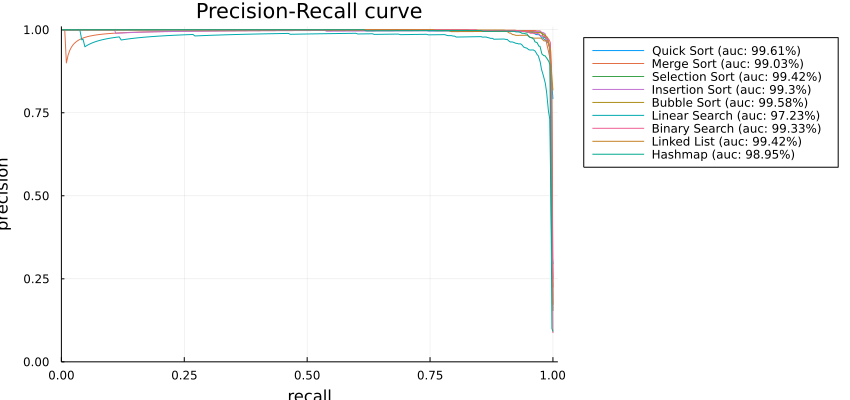

In [7]:
p = plot(size=(850, 400))

for (idx, label) ∈ enumerate(label_names)
    prplot!(p, targets[idx, :], predictions[idx, :], label=label, fill=false, legend=:outertopright)
end
p

For finding the optimal thresholds, we maximize the F1-score for each label

In [8]:
thresholds = 0.0:0.001:1.0 |> collect

change_nan(s) = isnan(s) ? 0 : s

for (idx, label) ∈ enumerate(label_names)
    f1_scores = thresholds .|> threshold -> f1_score(ConfusionMatrix(targets[idx, :], predictions[idx, :], threshold)) .|> change_nan
    jdx = argmax(f1_scores)
    decision_boundary = thresholds[jdx]
    println("$label => $decision_boundary | score: $(f1_scores[jdx])")
end

Quick Sort => 0.423 | score: 0.9787516600265603
Merge Sort => 0.725 | score: 0.9851598173515982
Selection Sort => 0.547 | score: 0.9840546697038726
Insertion Sort => 0.278 | score: 0.9860012172854534
Bubble Sort => 0.42 | score: 0.9850931677018634
Linear Search => 0.555 | score: 0.9496494582536648
Binary Search => 0.793 | score: 0.9820971867007673
Linked List => 0.231 | score: 0.9775280898876405
Hashmap => 0.849 | score: 0.9668737060041408


Also, we can find the optimal decision boundaries using the ROC Curve

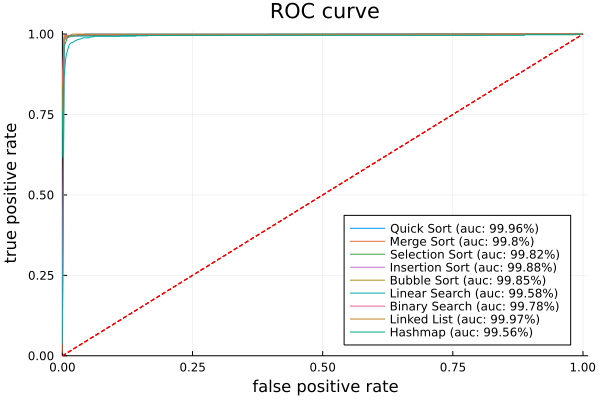

In [9]:
p = plot()

for (idx, label) ∈ enumerate(label_names)
    rocplot!(p, targets[idx, :], predictions[idx, :], label=label, fill=false)
end
p

We can find the optimal threshold using Youden's J Statistic

In [10]:
thresholds = 0.0:0.001:1.0 |> collect

j(sens, spec) = sens + spec - 1

for (idx, label) ∈ enumerate(label_names)
    confusion_matrices = thresholds .|> threshold -> ConfusionMatrix(targets[idx, :], predictions[idx, :], threshold)
    j_scores = confusion_matrices .|> conf -> j(sensitivity(conf), specificity(conf))
    jdx = argmax(j_scores)
    decision_boundary = thresholds[jdx]
    println("$label => $decision_boundary | score: $(j_scores[jdx])")
end

Quick Sort => 0.082 | score: 0.9852701226665708
Merge Sort => 0.196 | score: 0.980949030056967
Selection Sort => 0.036 | score: 0.9871261254369288
Insertion Sort => 0.048 | score: 0.9851518361257656
Bubble Sort => 0.176 | score: 0.9867308618199324
Linear Search => 0.203 | score: 0.9568227839110683
Binary Search => 0.252 | score: 0.9917122372098675
Linked List => 0.096 | score: 0.9894621375054791
Hashmap => 0.033 | score: 0.9822136038772722
